# Create and run Earthquake Estimator

In [1]:
!nvidia-smi

Mon Jan 28 08:27:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:81:00.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
import lstm_estimator
import earthquake_input_fn
import lstm_estimator_4096
from importlib import reload
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
import pickle
from glob import glob
%matplotlib inline

In [3]:
def reload_tf():
    global lstm_estimator
    global earthquake_input_fn
    global lstm_estimator_4096
    for i in range(2):
        import lstm_estimator
        import earthquake_input_fn
        import lstm_estimator_4096
        reload(lstm_estimator)
        reload(earthquake_input_fn)
        reload(lstm_estimator_4096)
        del lstm_estimator
        del earthquake_input_fn
        del lstm_estimator_4096
    import lstm_estimator
    import earthquake_input_fn
    import lstm_estimator_4096
reload_tf()

In [25]:
def create_estimator_4096_from_params(model_dir=None):
    
    if model_dir is None:
        raise Exception('you need to pass a model_dir for inference')
    
    params_file = osp.join(osp.split(model_dir)[0], osp.split(model_dir)[1] + '.params.pickle')
    if osp.isfile(params_file):
        print('reading params from %s' % params_file)
        with open(params_file, 'rb') as f:
            params = pickle.load(f)
    else:
        raise Exception('no model params found: expected a file %s' % params_file)
    
    params['batch_size'] = 1
    
    estim = tf.estimator.Estimator(model_fn=lstm_estimator_4096.lstm_4096_model_fn,
                                   params=params,
                                   model_dir=model_dir)
    return estim

In [27]:
def _deserialize_earthquakes2(serialized_examples):
    features = {
        'acousticdata': tf.FixedLenFeature((4096), tf.int64),
        'tminus': tf.FixedLenFeature((4096), tf.string)
    }
    features = tf.io.parse_single_example(
        serialized_examples,
        features=features
    )
    
    features['tminus'] = tf.strings.to_number(string_tensor=features['tminus'], out_type=tf.float64)
    features['acousticdata'] = tf.cast(features['acousticdata'], tf.float32)
    
    return ({'acousticdata': features['acousticdata'] / 5515.0}, features['tminus'] / 16.10)


In [28]:
def make_tfrecord_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    ds = tf.data.TFRecordDataset(files_ds)
    ds = ds.map(_deserialize_earthquakes2).batch(BATCH_SIZE)
    ds_iter = ds.make_one_shot_iterator()
    return ds_iter.get_next()

In [29]:
def predict_on_tfrecord(estimator, fn):
    return estim.predict(lambda: make_tfrecord_dataset([fn]), yield_single_examples=False)

In [30]:
def decode_tfrecord_files(files):
    print(len(files))
    ds_iter = make_tfrecord_dataset(files)
    retn = {}
    with tf.Session() as sess:
        for f in files:
            print(f)
            feats, labels = sess.run(ds_iter)
            retn[f] = {'x': feats['acousticdata'][0],
                       'y': labels[0]}
    return retn

In [31]:
def get_x_y_pred(estim, files):
    truedata = decode_tfrecord_files(files)
    for f in files:
        for pred in predict_on_tfrecord(estim, f):
            truedata[f]['pred'] = pred['pred'][0]
    return truedata

In [47]:
def create_pred_plots(model_dir, files):
    estim = create_estimator_4096_from_params(model_dir=model_dir)
    x_y_pred = get_x_y_pred(estim, files)
    for f in files:
        item = x_y_pred[f]
        x = item['x'] * 5515.0
        y = item['y'] * 16.1
        pred = item['pred'] * 16.1
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(y, x, label='actual')
        ax.plot(pred, x, label='pred')
        ax.set_title(f + '\nAbs err=%.4f' % abs(y[-1] - pred[-1]))
        ax.legend(loc=1)
        plt.show()
    fig, ax = plt.subplots(figsize=(12,7))
    ax.scatter(range(len(files)), [x_y_pred[f]['y'][-1] * 16.1 for f in files], label='true')
    ax.scatter(range(len(files)), [x_y_pred[f]['pred'][-1] * 16.1 for f in files], label='pred')
    ax.legend(loc=1)
    ax.set_title('all true vs pred')
    plt.show()
    
    print('MAE=%.4f' % np.mean(np.abs(np.asarray([x_y_pred[f]['y'][-1] * 16.1 for f in files]) - np.asarray([x_y_pred[f]['pred'][-1] * 16.1]))))

In [48]:
input_files = glob('/workspace/persistent-data/earthquake/tfrecords2/test/**/*.tfrecords')

reading params from /workspace/persistent-data/models/2019-01-28-07-46-22.params.pickle
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_global_id_in_cluster': 0, '_device_fn': None, '_task_type': 'worker', '_experimental_distribute': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0dbe354ac8>, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_eval_distribute': None, '_train_distribute': None, '_service': None, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_task_id': 0, '_protocol': None, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_model_dir': '/workspace/persistent-data/models/2019-01-28-07-46-22', '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
}
50
/workspace/pe

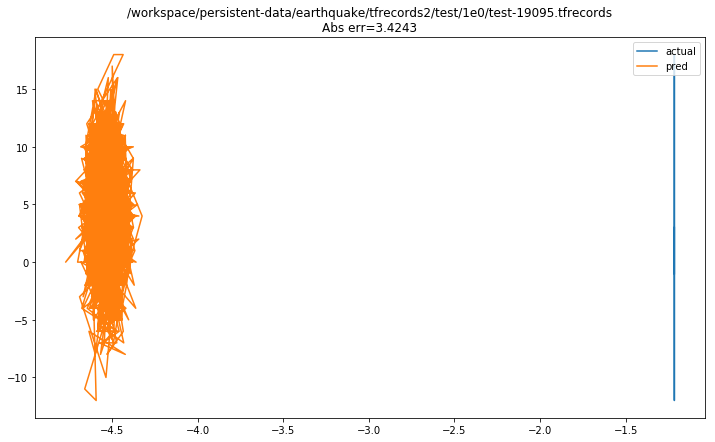

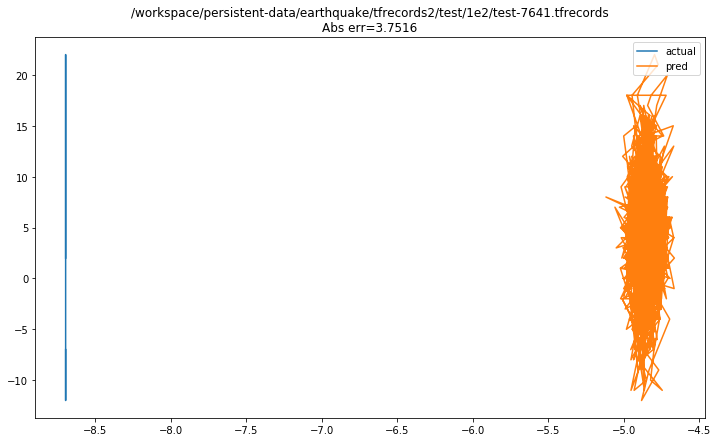

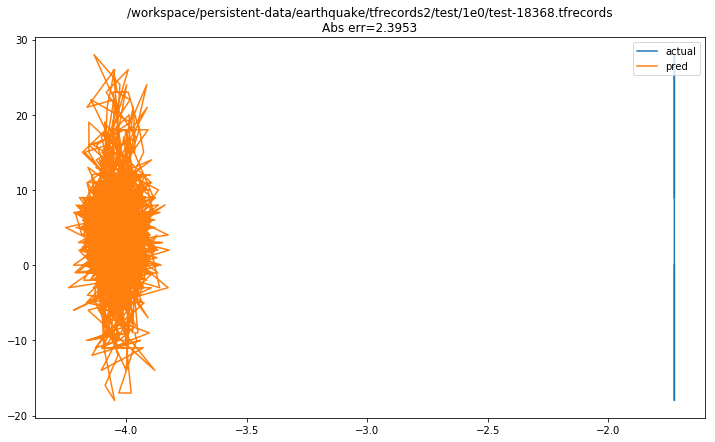

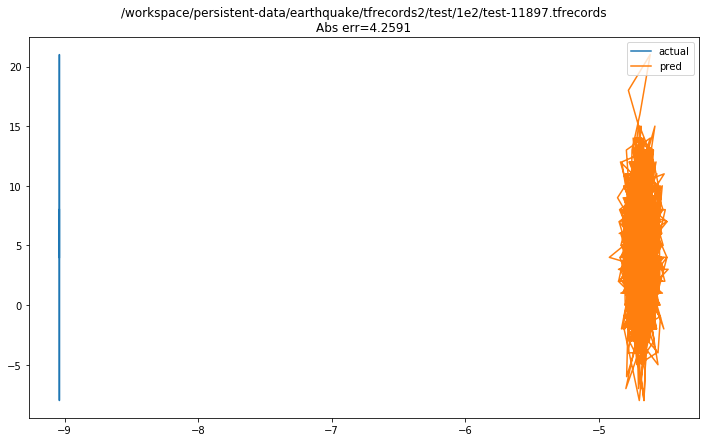

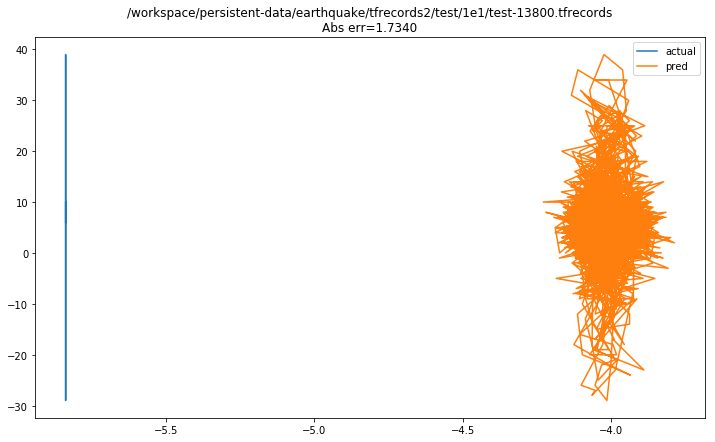

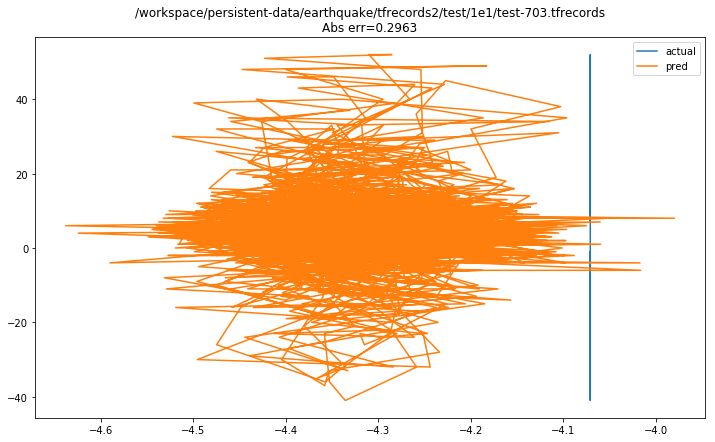

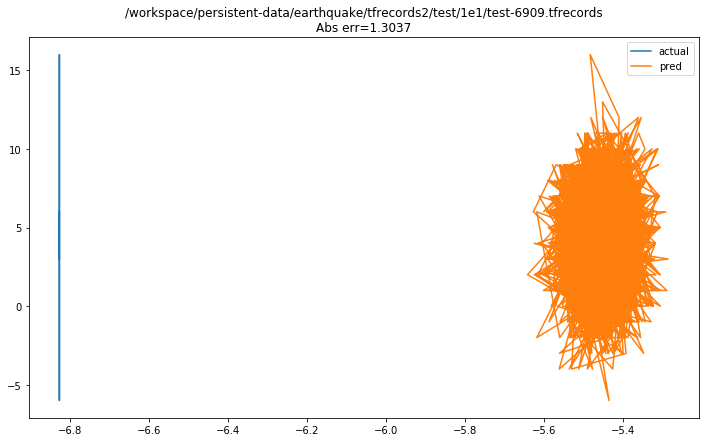

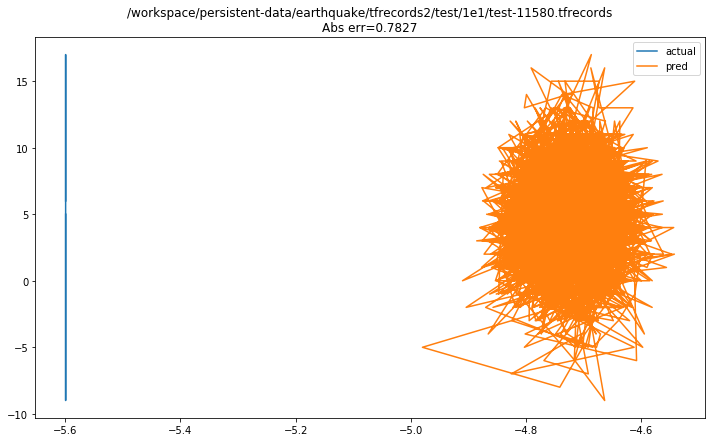

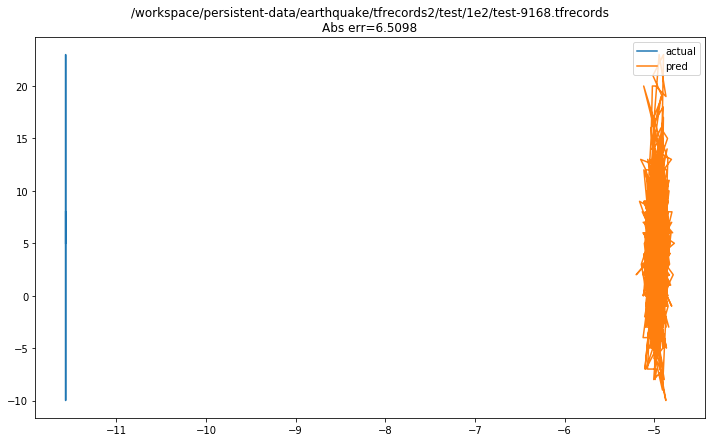

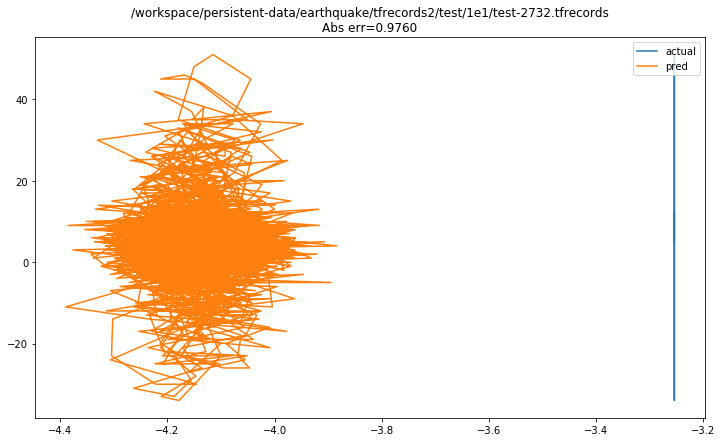

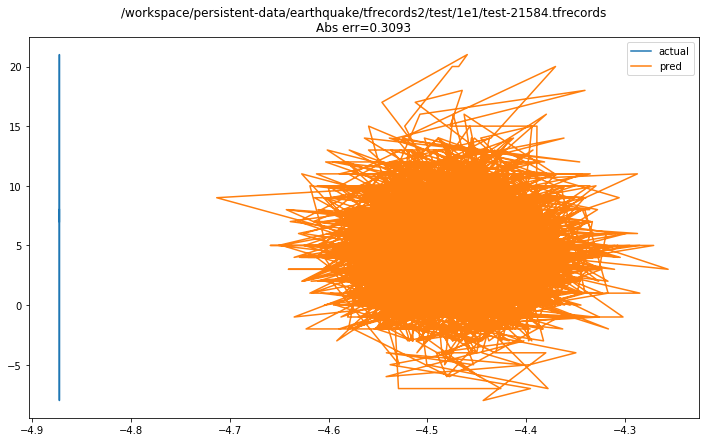

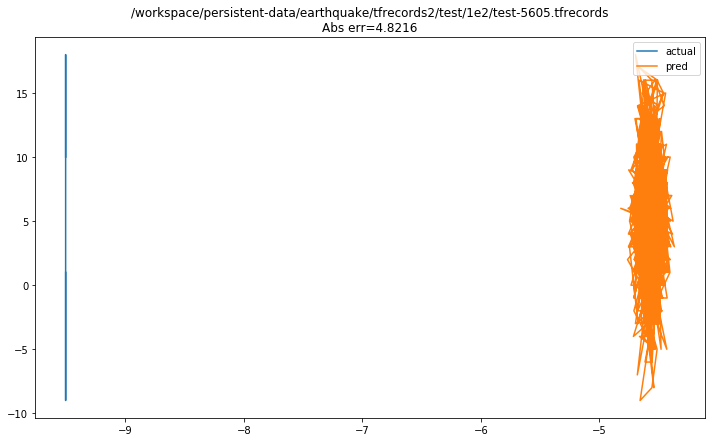

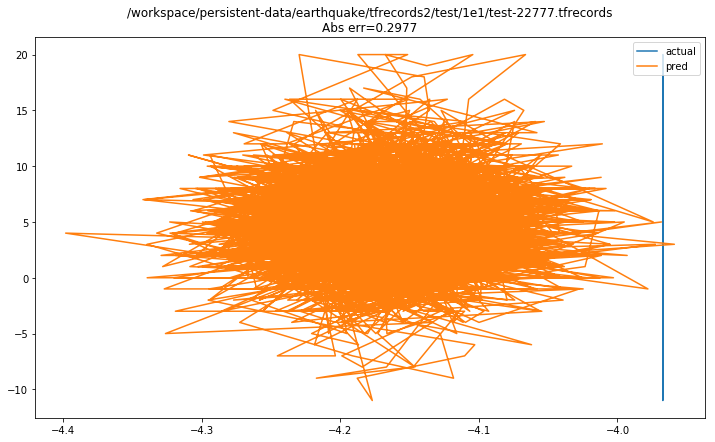

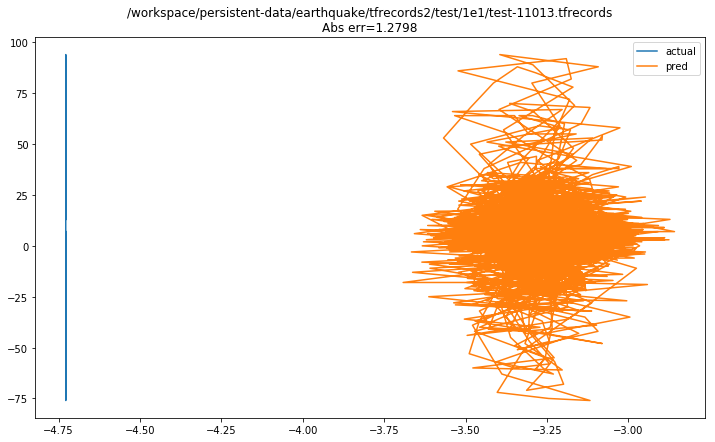

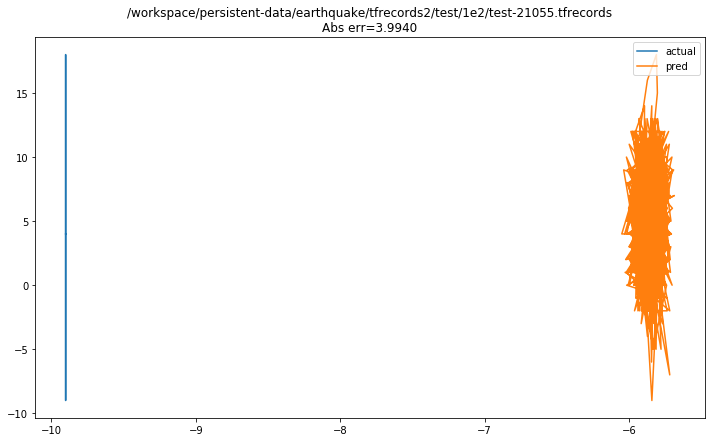

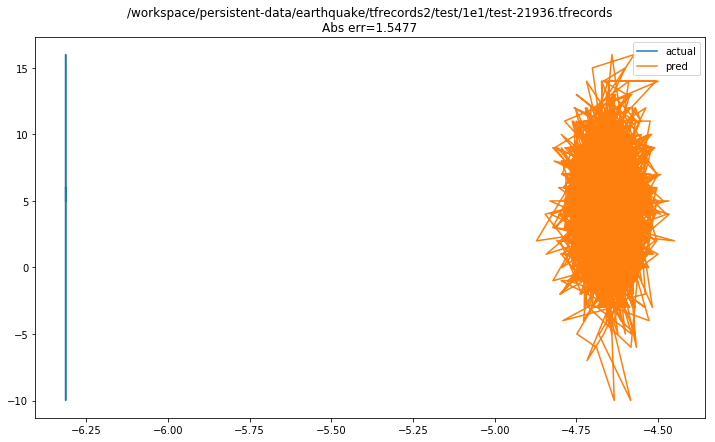

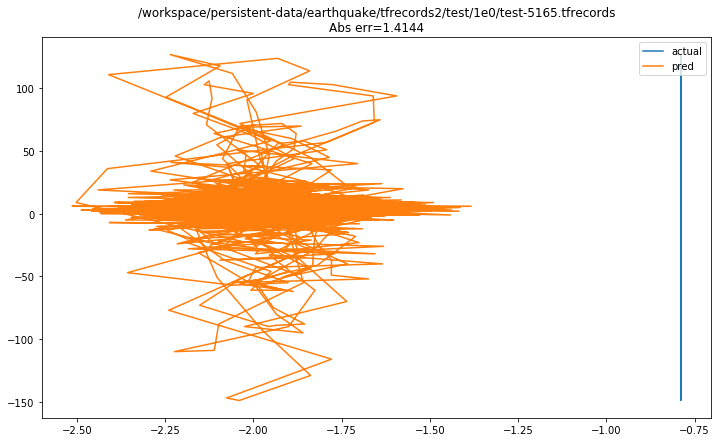

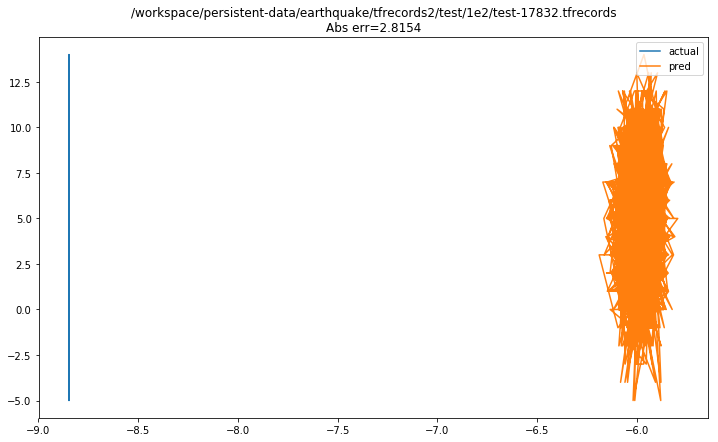

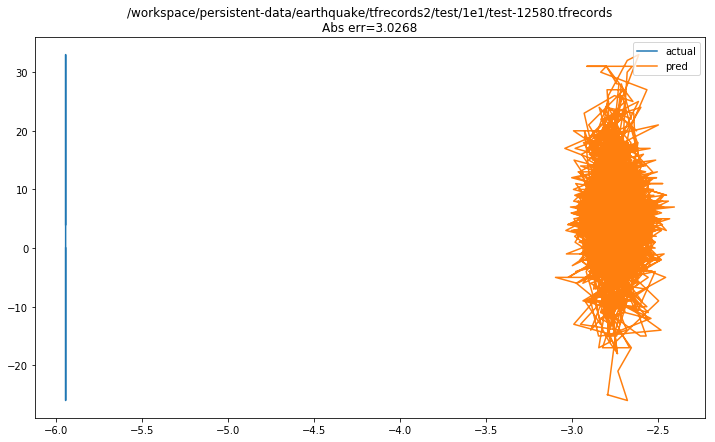

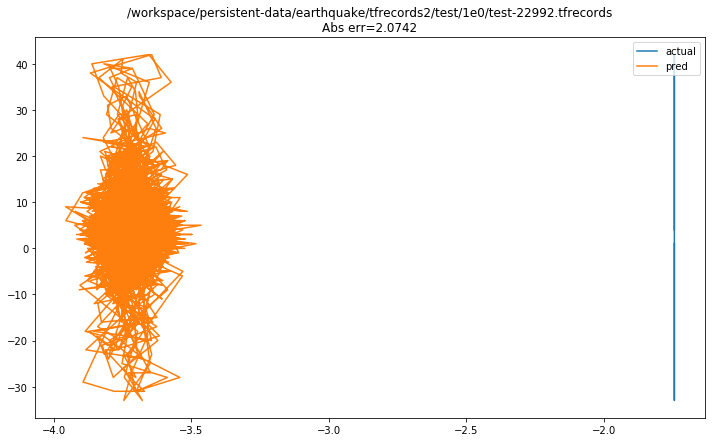

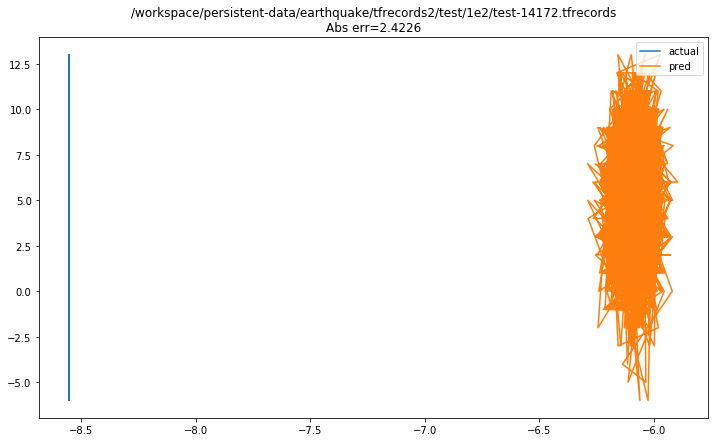

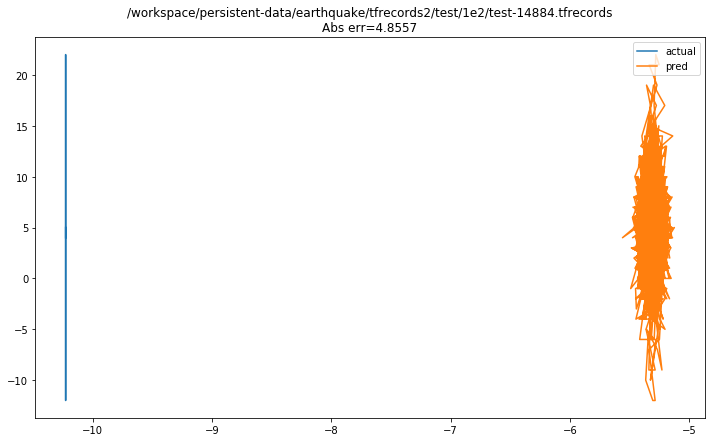

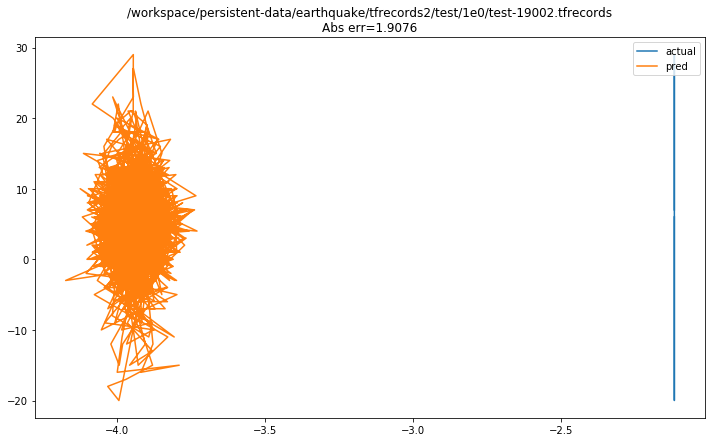

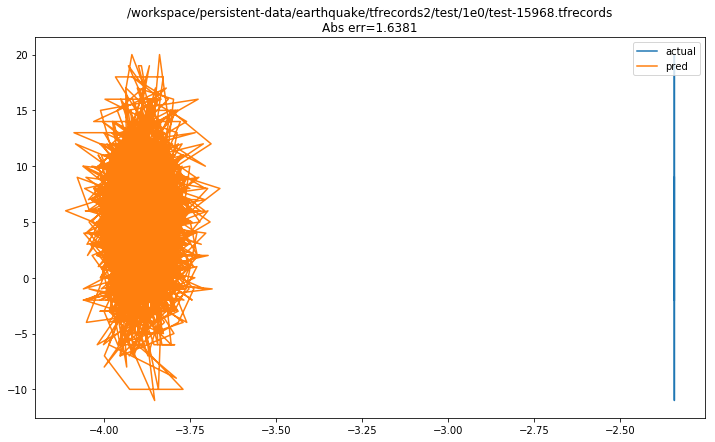

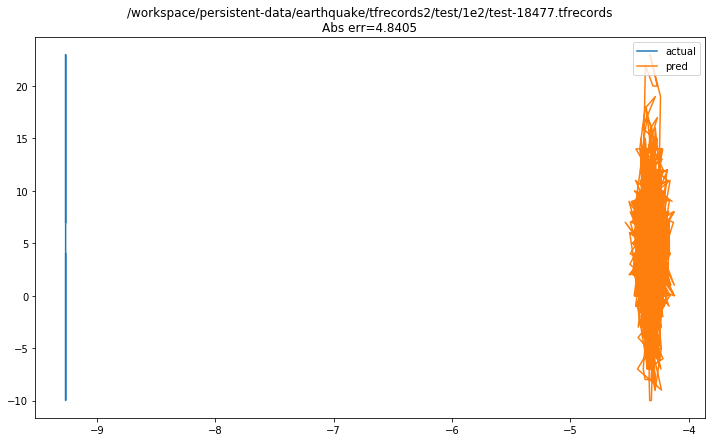

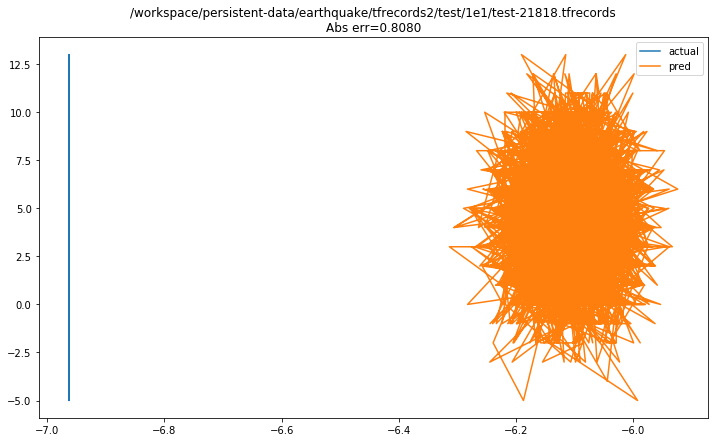

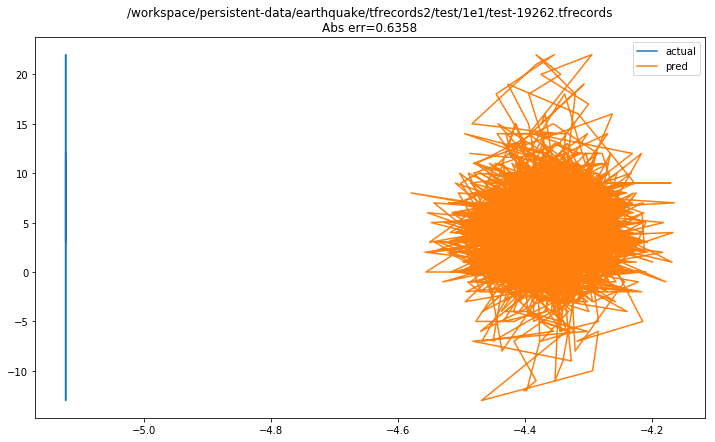

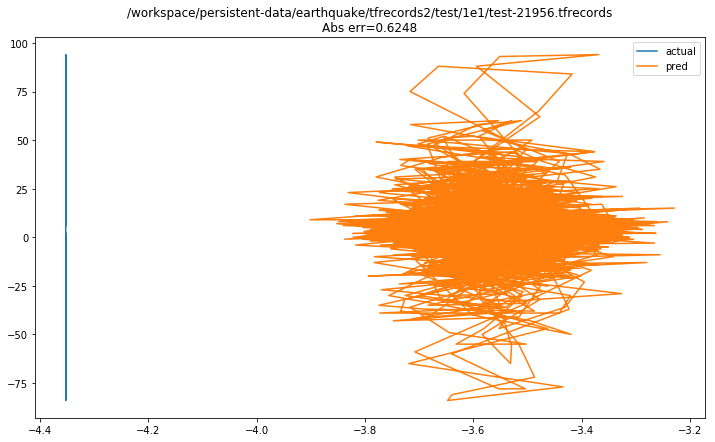

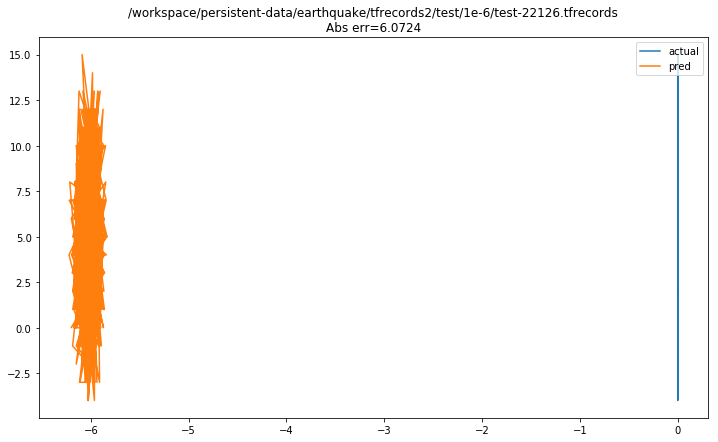

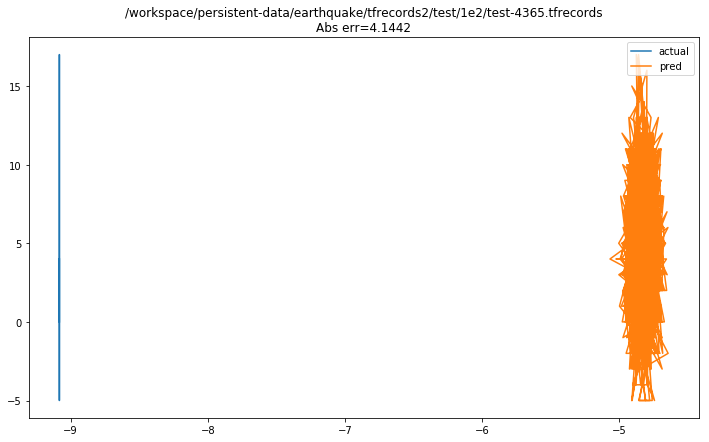

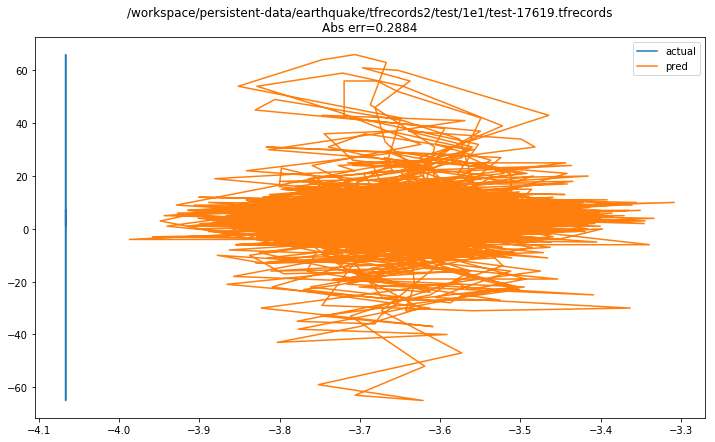

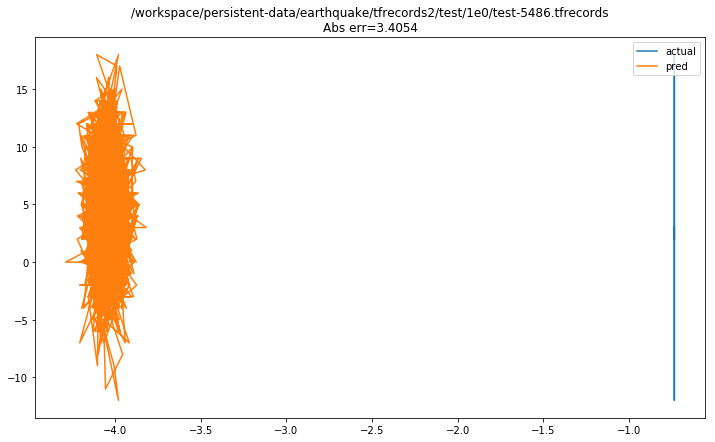

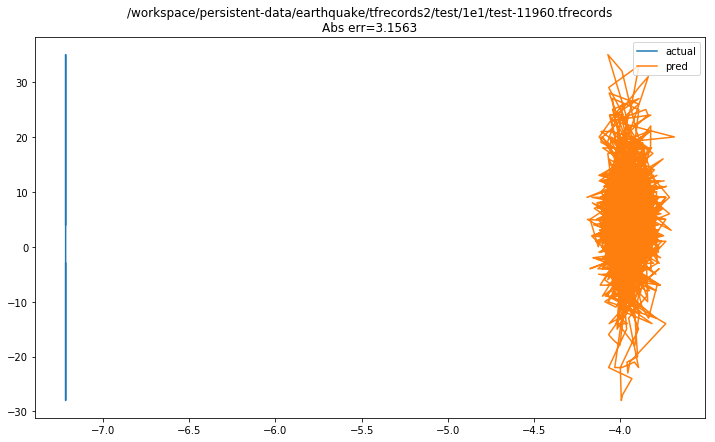

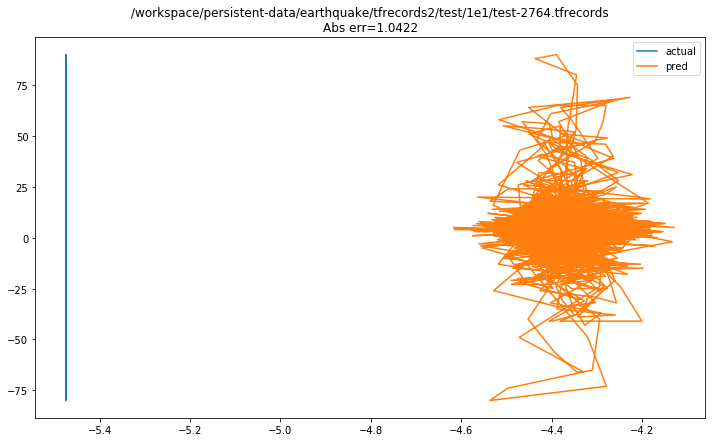

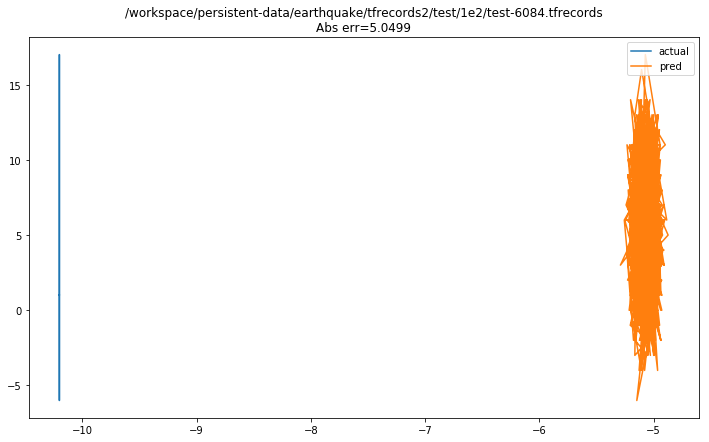

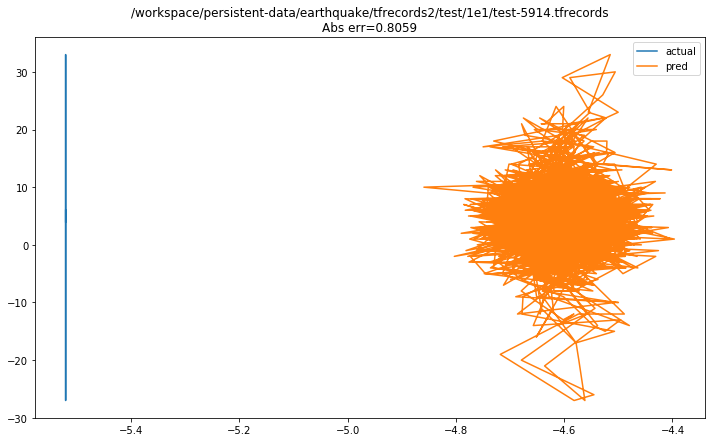

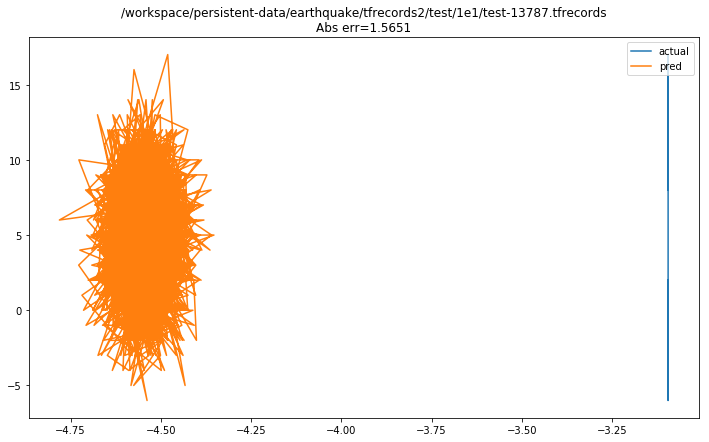

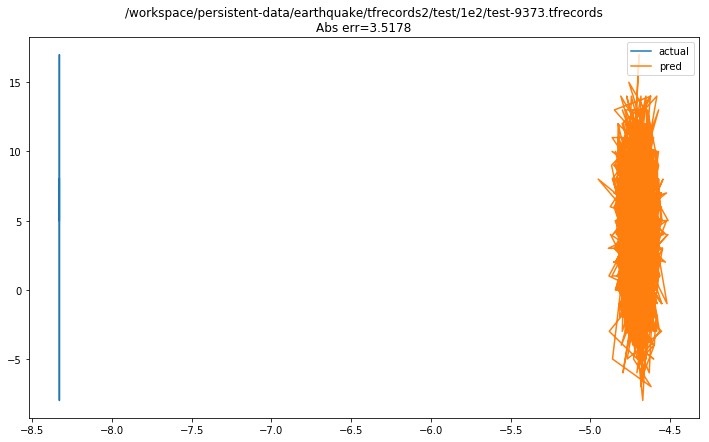

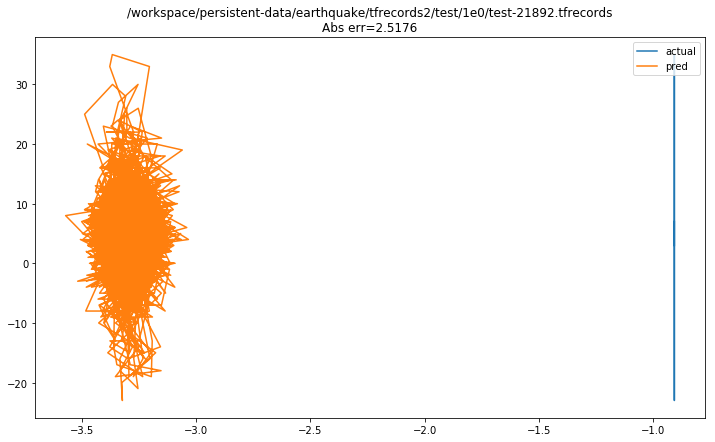

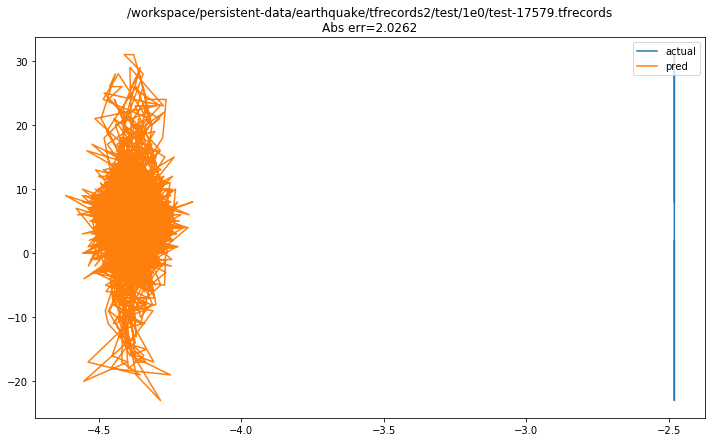

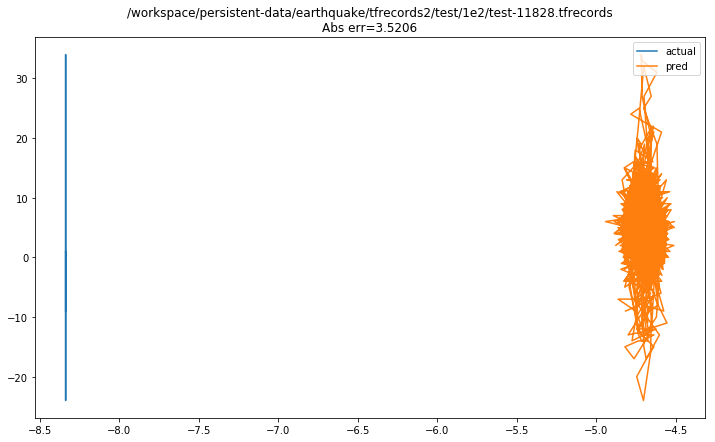

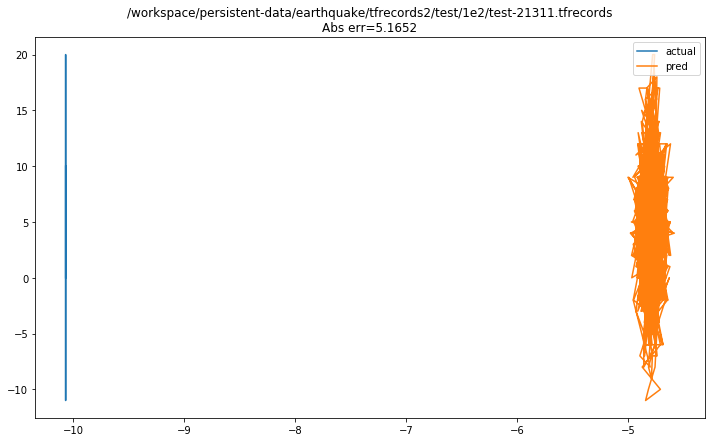

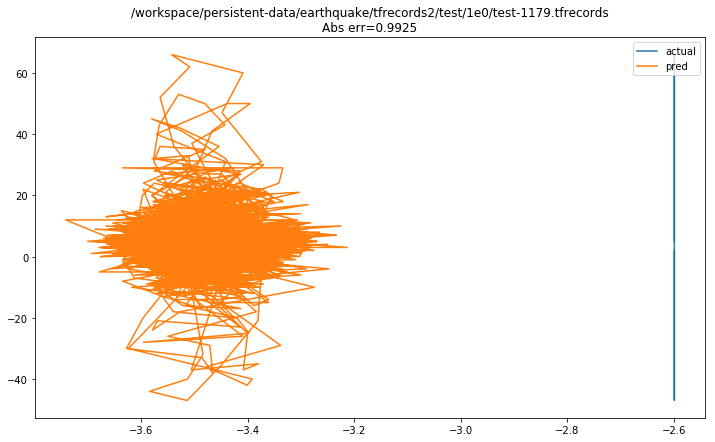

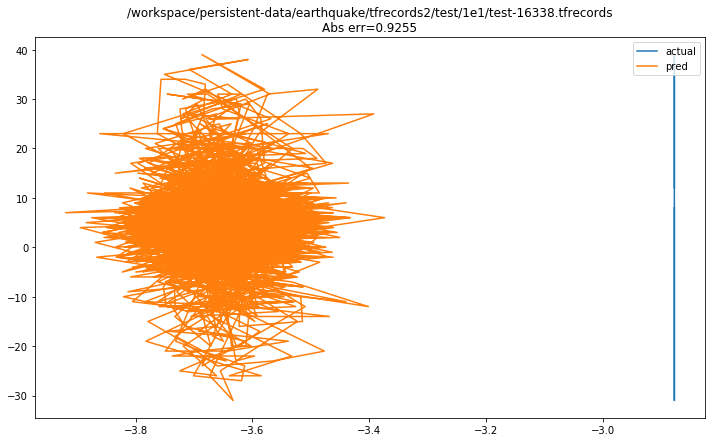

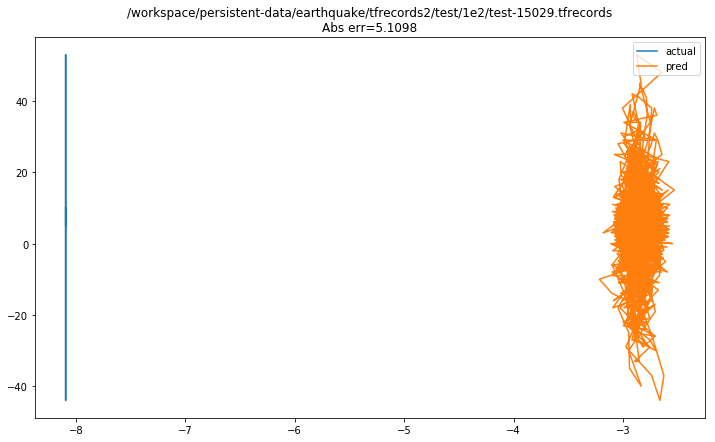

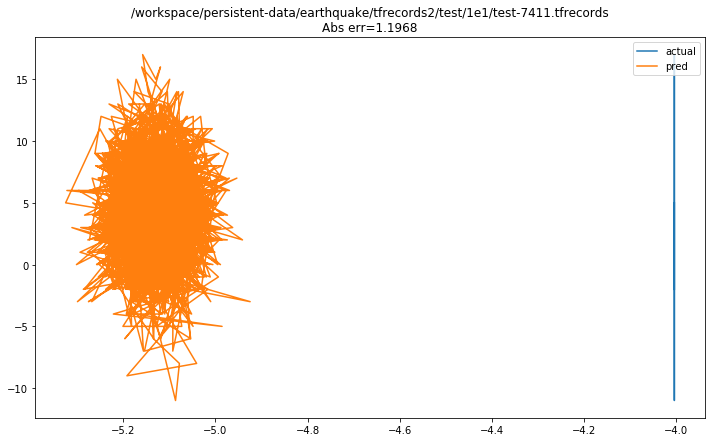

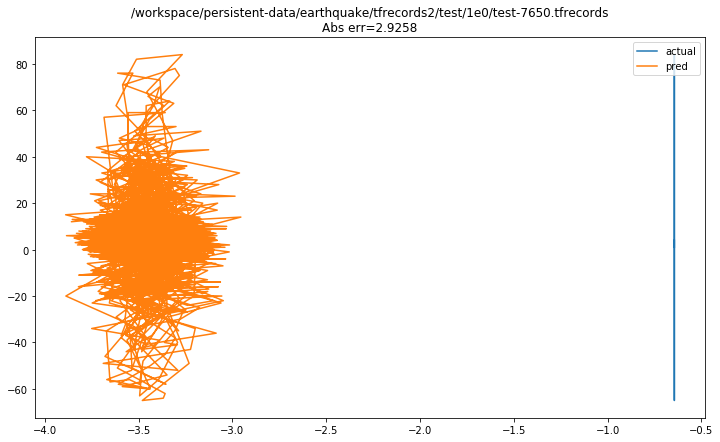

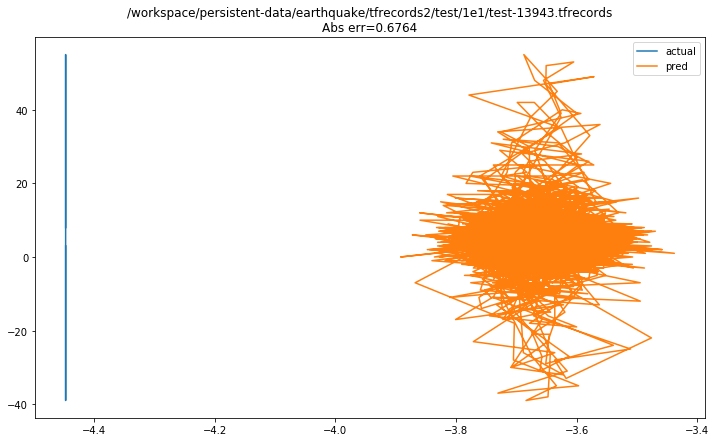

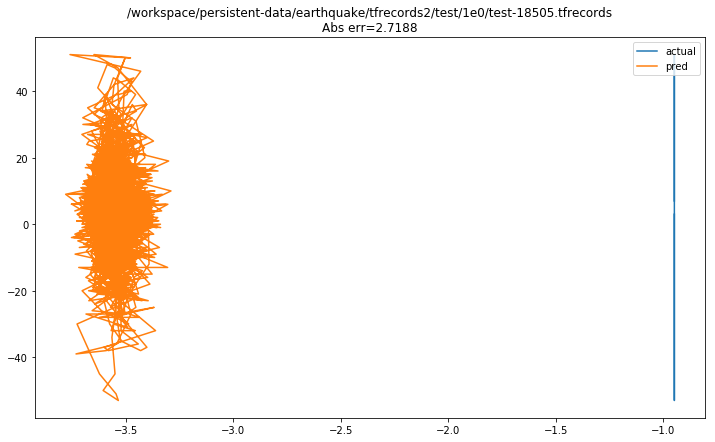

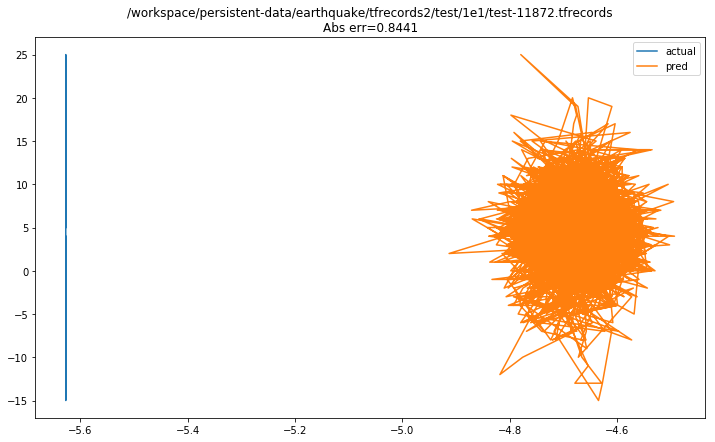

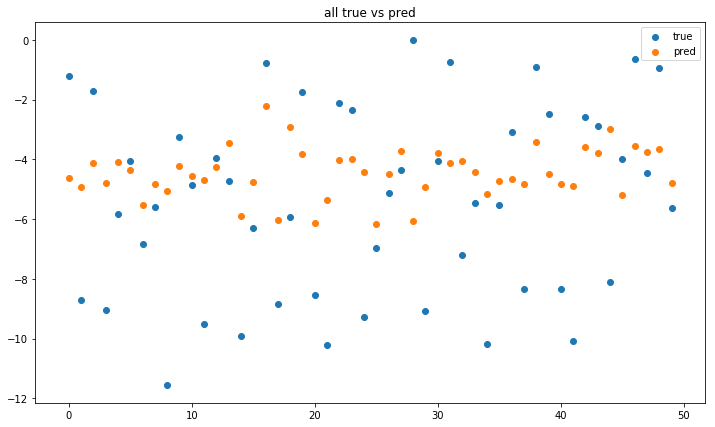

MAE=2.6955


In [50]:
create_pred_plots('/workspace/persistent-data/models/2019-01-28-07-46-22', np.random.permutation(input_files)[:50])